In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline                                           
from sklearn.preprocessing import StandardScaler                                     
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score as AUC
from sklearn.base import clone
from sklearn import tree
from sklearn.model_selection import ParameterGrid, GridSearchCV
from joblib import Parallel, delayed
from multiprocessing import Pool
from tqdm import tqdm
from scipy.spatial import distance
from skbio.stats.ordination import pcoa
import umap
from sklearn.metrics import make_scorer
from sklearn import linear_model
import warnings
warnings.filterwarnings("ignore")

# Get data

In [2]:
# read meta data
df_meta = pd.read_csv('../../../../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin'] # only for inulin group
df_meta = df_meta[df_meta.Day != 0] # remove day 0

# read SCFA data
df_scfa = pd.read_csv('../../../../../../our_data/SCFA.csv', index_col=0)

# read bacterial abundance (genus level)
df_bac = pd.read_csv('../../../../../../our_data/16S_absolute_abundance_genus.csv', index_col=0)

# find common samples
common_samples = list(set(df_meta.index).intersection(df_scfa.index).intersection(df_bac.index))
df_meta = df_meta.loc[common_samples]
df_scfa = df_scfa.loc[common_samples]
df_bac = df_bac.loc[common_samples]

# remove genes that are constant across all samples
df_bac = df_bac[list(df_bac.std()[df_bac.std()>0].index)]

# Run random forest model

## self-defined function

In [36]:
def get_weights(X, Z, method=None): # X is test and Z is train
    X.loc[:, "is_z"] = 0
    Z.loc[:, "is_z"] = 1
    XZ = pd.concat([X, Z],ignore_index=False) # keep index
    labels = XZ['is_z'].values
    XZ_mat = XZ.drop('is_z', axis=1).values
     
    # test if X and Z can be distinguished
    clf = RandomForestClassifier(n_estimators=100, max_depth=3,random_state=0)
    predictions = np.zeros(labels.shape)
    skf = SKF(n_splits=20, shuffle=True, random_state=0)
    for fold, (train_idx, test_idx) in enumerate(skf.split(XZ_mat, labels)):
        X_train, X_test = XZ_mat[train_idx,:], XZ_mat[test_idx,:]
        y_train, y_test = labels[train_idx], labels[test_idx]

        clf.fit(X_train, y_train)
        probs = clf.predict_proba(X_test)[:, 1] # probability that each data point is a sample from training set
        predictions[test_idx] = probs
    roc_auc = AUC(labels, predictions)
    
    # weight_i = p_i(X|D)/p_i(Z|D)
    predictions_Z = predictions[len(X):] # p(Z/D)
    weights = (1./predictions_Z) - 1. # p(X|D)/p(Z/D)
    weights /= np.mean(weights) # we do this to re-normalize the computed log-loss
    XZ['size'] = 4
    XZ.iloc[len(X):, XZ.columns.get_loc('size')] = 0.1 + weights*15
    
    # perform decomposition
    if method is not None:
        XZ = XZ.sort_index()
        XZ_mat = XZ.drop(['is_z','size'], axis=1).values

        # dimensionality reduction
        if method=='UMAP':
            fit = umap.UMAP(random_state=0)
            u = fit.fit_transform(XZ_mat)
            XZ_dec = pd.DataFrame(u, index=XZ.index, columns=['Axis1','Axis2'])
        elif method=='PCoA':
            dist_relab = distance.squareform(distance.pdist(XZ_mat, metric="braycurtis"))
            OrdinationResults = pcoa(dist_relab, number_of_dimensions=2)
            XZ_dec = pd.DataFrame(OrdinationResults.samples.values, index=XZ.index, columns=['Axis1','Axis2'])
        else:
            print('uknown method: %s'%(method))
            raise

        XZ_dec['is_z'] = XZ['is_z']
        XZ_dec['size'] = XZ['size']        
        return roc_auc, weights, XZ_dec
    else:
        return roc_auc, weights, XZ

## initialization

In [34]:
roc_auc = {}
results = []
use_weights=True
plot_weights=False

## intrapolation

Index(['sample100', 'sample111', 'sample112', 'sample113', 'sample114',
       'sample115', 'sample126', 'sample127', 'sample128', 'sample129',
       ...
       'sample80', 'sample81', 'sample82', 'sample83', 'sample84', 'sample85',
       'sample96', 'sample97', 'sample98', 'sample99'],
      dtype='object', name='SampleID', length=134)
[[    0.          0.     ]
 [27216.46127 18711.31712]]
ROC-AUC (A): 0.42
Index(['sample100', 'sample111', 'sample112', 'sample113', 'sample114',
       'sample115', 'sample126', 'sample127', 'sample128', 'sample129',
       ...
       'sample80', 'sample81', 'sample82', 'sample83', 'sample84', 'sample85',
       'sample96', 'sample97', 'sample98', 'sample99'],
      dtype='object', name='SampleID', length=134)
[[    0.          0.     ]
 [27216.46127 18711.31712]]
ROC-AUC (B): 0.49
Index(['sample100', 'sample111', 'sample112', 'sample113', 'sample114',
       'sample115', 'sample126', 'sample127', 'sample128', 'sample129',
       ...
       'sample80'

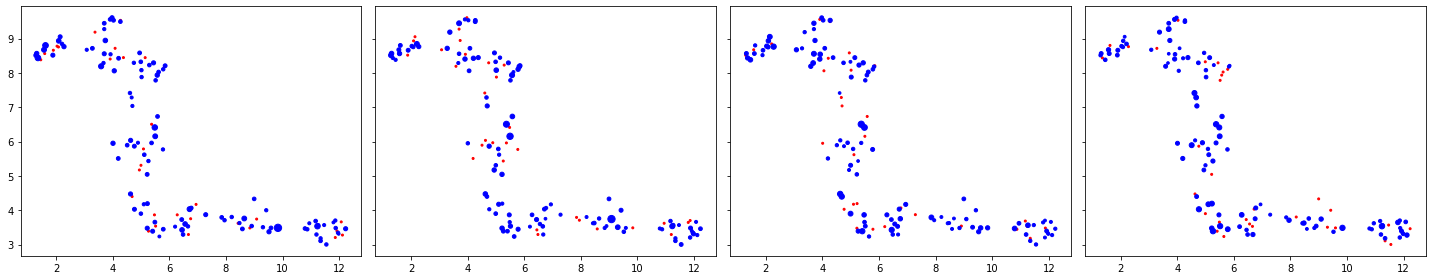

In [35]:
if use_weights and plot_weights:
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,4), sharex=True, sharey=True)

for k,group_to_exclude in enumerate(['A','B','C','D']):

    # split train/test data
    mice_to_keep = list(set(df_meta[df_meta.RandomizedGroup!=group_to_exclude].MiceID))
    samples_to_keep = list(set(df_meta[df_meta.MiceID.isin(mice_to_keep)].index))
    mice_to_exclude = list(set(df_meta[df_meta.RandomizedGroup==group_to_exclude].MiceID))
    samples_to_exclude = list(set(df_meta[df_meta.MiceID.isin(mice_to_exclude)].index))

    # get weights of training sets
    xdata_train = df_bac.loc[samples_to_keep]
    xdata_test = df_bac.loc[samples_to_exclude]
    if use_weights:        
        roc_auc[group_to_exclude], weights, df_ord = get_weights(X=deepcopy(xdata_test), Z=deepcopy(xdata_train), method='UMAP')
        assert len(xdata_train)==len(weights)
        print ("ROC-AUC (%s): %2.2f" % (group_to_exclude, roc_auc[group_to_exclude]))
     
        # show weights on train and test
        if plot_weights:
            # _ = sns.scatterplot(x='Axis1', y='Axis2', hue='is_z', size='size', data=df_ord, ax=ax[k])
            df_ord_0 = df_ord.loc[df_ord.is_z==0]
            _ = ax[k].scatter(df_ord_0['Axis1'], df_ord_0['Axis2'], marker='o', s=df_ord_0['size'], c='r', label='test')
            df_ord_1 = df_ord.loc[df_ord.is_z==1]
            _ = ax[k].scatter(df_ord_1['Axis1'], df_ord_1['Axis2'], marker='o', s=df_ord_1['size'], c='b', label='train')

    xdata_train = np.asarray(xdata_train.values)
    xdata_test = np.asarray(xdata_test.values)
    
    # run random forest regression with weights
    for scfa in ['Acetate','Propionate','Butyrate']:                
        ydata_train = np.asarray(df_scfa.loc[samples_to_keep, scfa])
        ydata_test = np.asarray(df_scfa.loc[samples_to_exclude, scfa])

        # make pipeline
        # use standardscaler for transformation
        # use lasso for feature selection
        # use random forest for prediction
        param_grid = {
            'selectfrommodel__estimator__alpha':[10**v for v in [-4,-3,-2,-1,0]], # too large alpha will produce a null model (all features are 0)
            'randomforestregressor__max_features':['auto','sqrt','log2',0.16,0.32,0.64],
            'randomforestregressor__max_depth':[2,4,8,16],
            'randomforestregressor__min_samples_split':[2,4,8,16],
            'randomforestregressor__min_samples_leaf':[1,2,4]
        }
        
        clf1 = linear_model.Lasso(tol=1e-5,positive=True,random_state=0,max_iter=1000000)
        clf2 = RandomForestRegressor(n_estimators=2000,random_state=0,oob_score=True)
        pipe = make_pipeline(StandardScaler(), SelectFromModel(clf1, threshold=1e-5), clone(clf2))  
        CV = GridSearchCV(pipe, param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=0)
        if use_weights:
            CV.fit(xdata_train, ydata_train, selectfrommodel__sample_weight=weights, randomforestregressor__sample_weight=weights)   
        else:
            CV.fit(xdata_train, ydata_train)

        print('Intrapolation, group %s, %s, best score and parameter combination = '%(group_to_exclude, scfa))
        print(CV.best_score_)    
        print(CV.best_params_)    
        print('\n')

        # predict training set
        ydata_train_predicted = CV.predict(xdata_train)
        ydata_test_predicted = CV.predict(xdata_test)

        for sample_, obs_, pred_ in zip(samples_to_keep, ydata_train, ydata_train_predicted):
            day_ = df_meta.loc[sample_,'Day']
            results.append(['intrapolation', scfa, group_to_exclude, 'train', sample_, day_, obs_, pred_])
        for sample_, obs_, pred_ in zip(samples_to_exclude, ydata_test, ydata_test_predicted):
            day_ = df_meta.loc[sample_,'Day']
            results.append(['intrapolation', scfa, group_to_exclude, 'test', sample_, day_, obs_, pred_])

if use_weights and plot_weights:
    plt.tight_layout()

## extrapolation

ROC-AUC (Beijing): 1.00
ROC-AUC (Guangdong): 1.00
ROC-AUC (Hunan): 1.00
ROC-AUC (Shanghai): 1.00


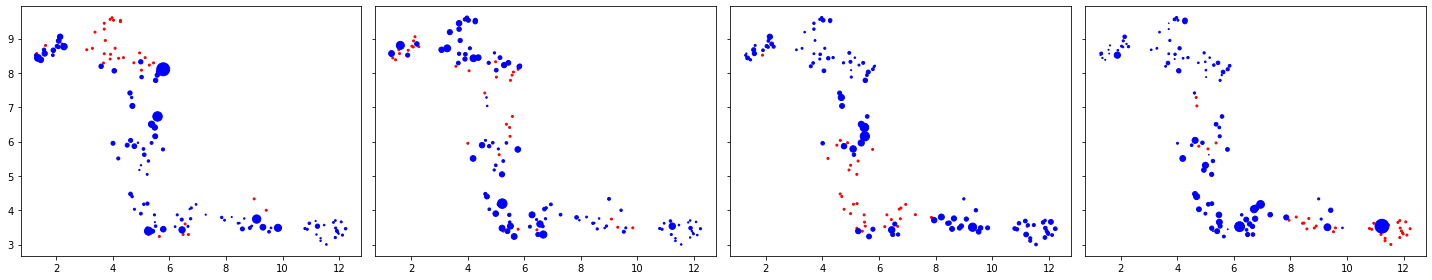

In [37]:
if use_weights and plot_weights:
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,4), sharex=True, sharey=True)

for k,vendor_to_exclude in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
        
    # split train/test data
    mice_to_keep = list(set(df_meta[df_meta.Vendor!=vendor_to_exclude].MiceID))
    samples_to_keep = list(set(df_meta[df_meta.MiceID.isin(mice_to_keep)].index))
    mice_to_exclude = list(set(df_meta[df_meta.Vendor==vendor_to_exclude].MiceID))
    samples_to_exclude = list(set(df_meta[df_meta.MiceID.isin(mice_to_exclude)].index))

    # get weights of training sets
    xdata_train = df_bac.loc[samples_to_keep]
    xdata_test = df_bac.loc[samples_to_exclude]
    if use_weights:
        roc_auc[vendor_to_exclude], weights, df_ord = get_weights(X=deepcopy(xdata_test), Z=deepcopy(xdata_train), method='UMAP')
        assert len(xdata_train)==len(weights)
        print ("ROC-AUC (%s): %2.2f" % (vendor_to_exclude, roc_auc[vendor_to_exclude]))
    
        # show weights on train and test
        if plot_weights:
            # _ = sns.scatterplot(x='Axis1', y='Axis2', hue='is_z', size='size', data=df_ord, ax=ax[k])
            df_ord_0 = df_ord.loc[df_ord.is_z==0]
            _ = ax[k].scatter(df_ord_0['Axis1'], df_ord_0['Axis2'], marker='o', s=df_ord_0['size'], c='r', label='test')
            df_ord_1 = df_ord.loc[df_ord.is_z==1]
            _ = ax[k].scatter(df_ord_1['Axis1'], df_ord_1['Axis2'], marker='o', s=df_ord_1['size'], c='b', label='train')

    xdata_train = np.asarray(xdata_train.values)
    xdata_test = np.asarray(xdata_test.values)
    
    # run random forest regression with weights
    for scfa in ['Acetate','Propionate','Butyrate']:                
        ydata_train = np.asarray(df_scfa.loc[samples_to_keep, scfa])
        ydata_test = np.asarray(df_scfa.loc[samples_to_exclude, scfa])

        # make pipeline
        # use lasso for feature selection
        param_grid = {
            'selectfrommodel__estimator__alpha':[10**v for v in [-4,-3,-2,-1,0]], # too large alpha will produce a null model (all features are 0)
            'randomforestregressor__max_features':['auto','sqrt','log2',0.16,0.32,0.64],
            'randomforestregressor__max_depth':[2,4,8,16],
            'randomforestregressor__min_samples_split':[2,4,8,16],
            'randomforestregressor__min_samples_leaf':[1,2,4]
        }
        
        clf1 = linear_model.Lasso(tol=1e-5,positive=True,random_state=0,max_iter=1000000)
        clf2 = RandomForestRegressor(n_estimators=2000,random_state=0,oob_score=True)
        pipe = make_pipeline(StandardScaler(), SelectFromModel(clf1, threshold=1e-5), clone(clf2))  
        CV = GridSearchCV(pipe, param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=0)
        if use_weights:
            CV.fit(xdata_train, ydata_train, selectfrommodel__sample_weight=weights, randomforestregressor__sample_weight=weights)
        else:
            CV.fit(xdata_train, ydata_train)

        print('Extrapolation, vendor %s, %s, best score and parameter combination = '%(vendor_to_exclude, scfa))
        print(CV.best_score_)    
        print(CV.best_params_)    
        print('\n')   

        # predict training set
        ydata_train_predicted = CV.predict(xdata_train)
        ydata_test_predicted = CV.predict(xdata_test)

        for sample_, obs_, pred_ in zip(samples_to_keep, ydata_train, ydata_train_predicted):
            day_ = df_meta.loc[sample_,'Day']
            results.append(['extrapolation', scfa, vendor_to_exclude, 'train', sample_, day_, obs_, pred_])
        for sample_, obs_, pred_ in zip(samples_to_exclude, ydata_test, ydata_test_predicted):
            day_ = df_meta.loc[sample_,'Day']
            results.append(['extrapolation', scfa, vendor_to_exclude, 'test', sample_, day_, obs_, pred_])

if use_weights and plot_weights:
    plt.tight_layout()

## save results to file

In [8]:
df_roc_w_weights = pd.DataFrame.from_dict(roc_auc, orient='index').rename({0:'AUC'}, axis=1)
df_roc_w_weights

,AUC
A,0.418728
B,0.508299
C,0.476923
D,0.625117
Beijing,0.997691
Guangdong,0.997855
Hunan,1.000000
Shanghai,0.999423


In [7]:
df_prediction = pd.DataFrame(results, columns=['PerturbationType','SCFA','Permutation','PredictionType','SampleID','Day','ObservedValue','PredictedValue'])
if use_weights:
    df_prediction.to_csv('rf_prediction_predictor_genusonly_w_weights.csv')
else:
    df_prediction.to_csv('rf_prediction_predictor_genusonly_wo_weights.csv')